<a href="https://colab.research.google.com/github/ossamum/google-meridian/blob/main/Google_Meridian_Simulated_Data_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Marketing Mix Modeling (MMM) – Analysis & Optimization Overview

This notebook walks through the **end-to-end process** of building, diagnosing, and using a Marketing Mix Model (MMM) to understand the impact of media spend and external factors on key business outcomes (e.g., conversions, revenue).

---

## 1. **Data Exploration & Preparation**
We start by loading simulated marketing datasets and:
- Cleaning and structuring them into **Meridian’s expected schema**.
- Grouping media into:
  - **Impressions-based channels** – measure exposure volume.
  - **Reach/frequency channels** – measure audience breadth and repetition.
- Adding control variables for market conditions, competition, and geo-level attributes.

**Goal:** Ensure the model receives clean, well-labeled inputs that reflect the true analytical role of each variable.

---

## 2. **Exploratory Analysis**
We visualize and summarize:
- Time trends in impressions, spend, and conversions.
- Seasonal patterns and long-term trends in KPIs.
- Correlations between channels, external drivers, and outcomes.
- Lag effects to see how quickly impressions convert into results.

**Goal:** Build intuition about data patterns before modeling.

---

## 3. **Priors & Model Specification**
Since this is an exercise without strong external benchmarks, we:
- Use **data-guided priors** to remain honest about uncertainty.
- Specify ROI priors with a **log-normal distribution** to reflect positivity and skew.
- Configure model flexibility with spline knots for **diminishing returns**.

**Goal:** Give the model realistic but non-restrictive starting points for learning.

---

## 4. **Model Fitting & Diagnostics**
We fit the MMM and check:
- **Convergence** using R-hat statistics.
- **Fit quality** by comparing predicted vs. actual KPIs.
- **Parameter plausibility** (ROI, adstock, saturation).

**Goal:** Ensure results are statistically sound and trustworthy.

---

## 5. **Results & Insights**
From the fitted model, we extract:
- **Channel contributions** – how much each channel adds to KPI lift.
- **ROI estimates** – efficiency of each channel.
- **Baseline performance** – KPI without media.

**Goal:** Quantify media impact and efficiency for decision-making.

---

## 6. **Budget Optimization**
Using the model’s outputs, we simulate:
- **Optimal spend allocation** to maximize KPI within current budget.
- **Projected KPI lift** under the optimized mix.
- **Marginal ROI balancing** to avoid overspending in low-impact areas.

**Goal:** Turn insights into **actionable recommendations** for media planning.

---

## 7. **How to Use This Notebook**
- **Non-technical readers:** Focus on plots, high-level summaries, and the *Insights* sections after each analysis.
- **Decision-makers:** Pay attention to the **ROI, contribution, and optimization results** for actionable guidance.
- **Analysts:** Refer to the code cells and diagnostic sections to understand how results are derived and validated.

---

**In short:**  
This notebook shows how data can be transformed into **clear, actionable marketing insights**—from understanding historical performance to recommending the optimal budget split for maximum business impact.


# Importings

In [1]:
# Install meridian: from PyPI @ latest release
!pip install -q --upgrade google-meridian[colab,and-cuda]

# Install meridian: from PyPI @ specific version
# !pip install google-meridian[colab,and-cuda]==1.1.1

# Install meridian: from GitHub @HEAD
# !pip install --upgrade "google-meridian[colab,and-cuda] @ git+https://github.com/google/meridian.git@main"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 w

In [21]:
import arviz as az
import IPython
from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import formatter
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.data import data_frame_input_data_builder
from meridian.data import test_utils

from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec
import numpy as np
import pandas as pd
# check if GPU is available
from psutil import virtual_memory
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print(
    'Num GPUs Available: ',
    len(tf.config.experimental.list_physical_devices('GPU')),
)
print(
    'Num CPUs Available: ',
    len(tf.config.experimental.list_physical_devices('CPU')),
)

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  1
Num CPUs Available:  1


In [3]:
pd.options.display.max_columns = None

# Data loading and processing

In [5]:
df = pd.read_csv('Simulated_Data_RF.csv').drop(columns=['Unnamed: 0'])
df.shape

(6240, 25)

## Dataset Description – `Simulated_Data_RF.csv`

This dataset contains **geo-level, time-series marketing and performance data** combining both **impressions-based** and **reach/frequency-based** media channels, along with external drivers and business outcomes.  
It is structured to support **media mix modeling (MMM)** at a granular, regional level.

### Structure
- **Unit of observation:** Weekly data by `geo`.
- **Period covered:** Multiple weeks starting from 2021-01-25 (sample shown).
- **Granularity:** Regional (`geo`), with population and geo-tier metadata.

### Key Column Groups
1. **Identifiers & Time**
   - `geo`: Regional market code (e.g., `Geo0`).
   - `time`: Week start date.

2. **Media Exposure – Impressions-based**
   - `Channel0_impression` to `Channel3_impression` – Weekly ad impressions by channel.

3. **Media Exposure – Reach/Frequency-based**
   - `Channel4_impression`, `Channel5_impression` – Derived impressions.
   - `Channel4_reach`, `Channel5_reach` – Number of unique individuals reached.
   - `Channel4_frequency`, `Channel5_frequency` – Average exposures per reached individual.

4. **External Factors**
   - `Competitor_Discount`: Competitor activity index (e.g., average discount rate).
   - `GQV`: Gross Query Volume, a proxy for market demand.
   - `Geo_GDP`: Regional economic indicator.

5. **Media Spend**
   - `Channel0_spend` to `Channel5_spend` – Weekly spend per channel.

6. **Performance Metrics**
   - `conversions`: Number of desired outcomes (e.g., purchases, sign-ups).
   - `revenue_per_conversion`: Average revenue per conversion.

7. **Geo Metadata**
   - `population`: Regional population size.
   - `geo_tier`: Market tier classification (e.g., 1 = large urban).

### Key Characteristics
- **Sparse Media Activity:** Many weeks show zero spend/impressions for certain channels, simulating burst campaigns.
- **Mixed Media Types:** Channels 0–3 use impressions-based measurement; Channels 4–5 are modeled via reach and frequency, enabling different response modeling approaches.
- **Rich Controls:** External factors (`Competitor_Discount`, `GQV`, `Geo_GDP`) and geo attributes support controlling for non-media influences.
- **Granular Segmentation:** Geo-level breakdown allows for cross-market comparison and pooling in hierarchical models.

### Intended Use
The dataset is designed for:
- Multi-geo MMM calibration.
- Comparing performance across **impressions-based** and **reach/frequency-based** channels.
- Testing the effect of market conditions on media effectiveness.


In [ ]:
df.head(3)

,geo,time,Channel0_impression,Channel1_impression,Channel2_impression,Channel3_impression,Channel4_impression,Channel5_impression,Competitor_Discount,GQV,Geo_GDP,Channel0_spend,Channel1_spend,Channel2_spend,Channel3_spend,Channel4_spend,Channel5_spend,conversions,revenue_per_conversion,population,geo_tier,Channel4_reach,Channel5_reach,Channel4_frequency,Channel5_frequency
0,Geo0,2021-01-25,0.0,0.0,0.0,549315.0,283116.0,0.0,0.826073,-1.128607,-1.695445,0.000,0.0000,0.000,4264.9795,2305.556,0.00000,9108830.0,0.020016,574674.6,2,228583.0,0.0,1.23857,0.000000
1,Geo0,2021-02-01,0.0,0.0,0.0,0.0,0.0,0.0,-1.003415,-2.316145,0.109141,0.000,0.0000,0.000,0.0000,0.000,0.00000,8093423.0,0.020054,574674.6,2,0.0,0.0,0.00000,0.000000
2,Geo0,2021-02-08,547840.0,242085.0,1003156.0,436785.0,0.0,75885.0,1.797497,-0.359717,-1.601492,4701.699,2400.4517,8756.294,3391.2766,0.000,594.79785,11142771.0,0.020002,574674.6,2,0.0,65079.0,0.00000,1.166044


In [6]:
df['geo'].nunique()

40

In [7]:
df['time'].min(), df['time'].max()

('2021-01-25', '2024-01-15')

In [8]:
# check if any null values
assert df.isna().sum().any() == False

# Exploratory Data Analysis (EDA)

In [12]:
decomposition = seasonal_decompose(df.groupby('time')['conversions'].sum(), model='additive', period=52)

## Seasonal Decomposition of Conversions

The plot breaks down the **weekly conversions** into four components to better understand underlying patterns:

1. **Observed (Top Panel)**  
   - Represents the raw conversion time series.
   - Shows weekly fluctuations with noticeable short-term variability.

2. **Trend (Second Panel)**  
   - Captures the long-term progression in conversions, smoothing out noise.
   - Displays a steady upward movement until around mid-period, followed by a slight decline.
   - Suggests possible market saturation or external factors affecting demand later in the series.

3. **Seasonal (Third Panel)**  
   - Reveals repeating patterns across weeks.
   - Indicates cyclical peaks and troughs, possibly linked to marketing campaigns, seasonality, or recurring external factors.

4. **Residual (Bottom Panel)**  
   - Contains the random noise after removing trend and seasonality.
   - Points scattered around zero suggest no strong unexplained structure remains, though some outliers appear.

### Insights
- The combination of upward trend (early) and stable cyclical seasonality suggests **both sustained growth and recurring demand drivers**.


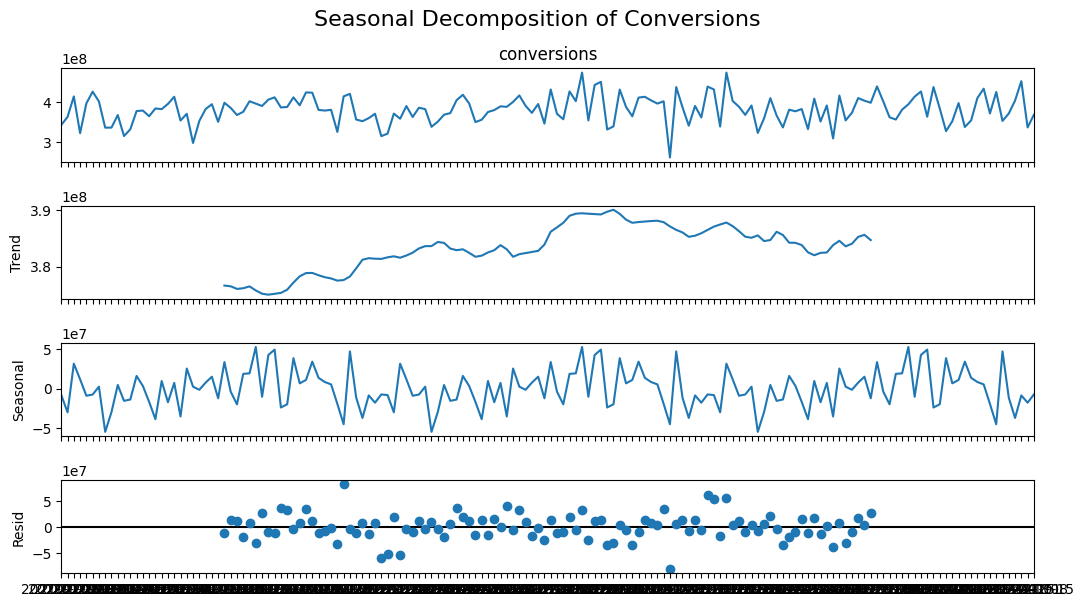

In [13]:
# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.suptitle('Seasonal Decomposition of Conversions', fontsize=16, y=1.02)
plt.show()

## Correlation Clustermap – Impressions, External Factors & Outcomes

This clustermap visualizes the **pairwise correlations** among channel impressions, external market factors, and key outcomes (conversions, revenue per conversion).

### Key Observations
- **Channel Impression Clustering:**  
  Impressions from all six channels are **positively correlated** with each other, with correlations ranging roughly from 0.36 to 0.57. This suggests that marketing activity often scales across channels simultaneously.

- **Impressions vs. Conversions:**  
  All channel impressions have a **moderate positive correlation**. This reinforces that higher exposure generally leads to higher conversions.

- **External Factor Relationships:**  
  - `GQV` shows moderate correlation with impressions and conversions.  
  - `Geo_GDP` has a weaker but positive association with impressions and conversions.  
  - `Competitor_Discount` exhibits mixed correlations — slightly negative with `Geo_GDP` but modestly positive with some impressions.

- **Revenue per Conversion:**  
  This metric is largely **uncorrelated** with impressions or conversions, suggesting that while exposure drives volume, it does not strongly impact average conversion value.

### Insights
- Coordinated increases in impressions across channels indicate **joint media planning or market-wide campaign pushes**.  
- External demand signals (`GQV`, `Geo_GDP`) and competitive activity play a **supporting role** but do not dominate the correlation structure.  
- Since conversions are consistently linked to impressions, **channel investment optimization should focus on balancing reach with marginal ROI**.


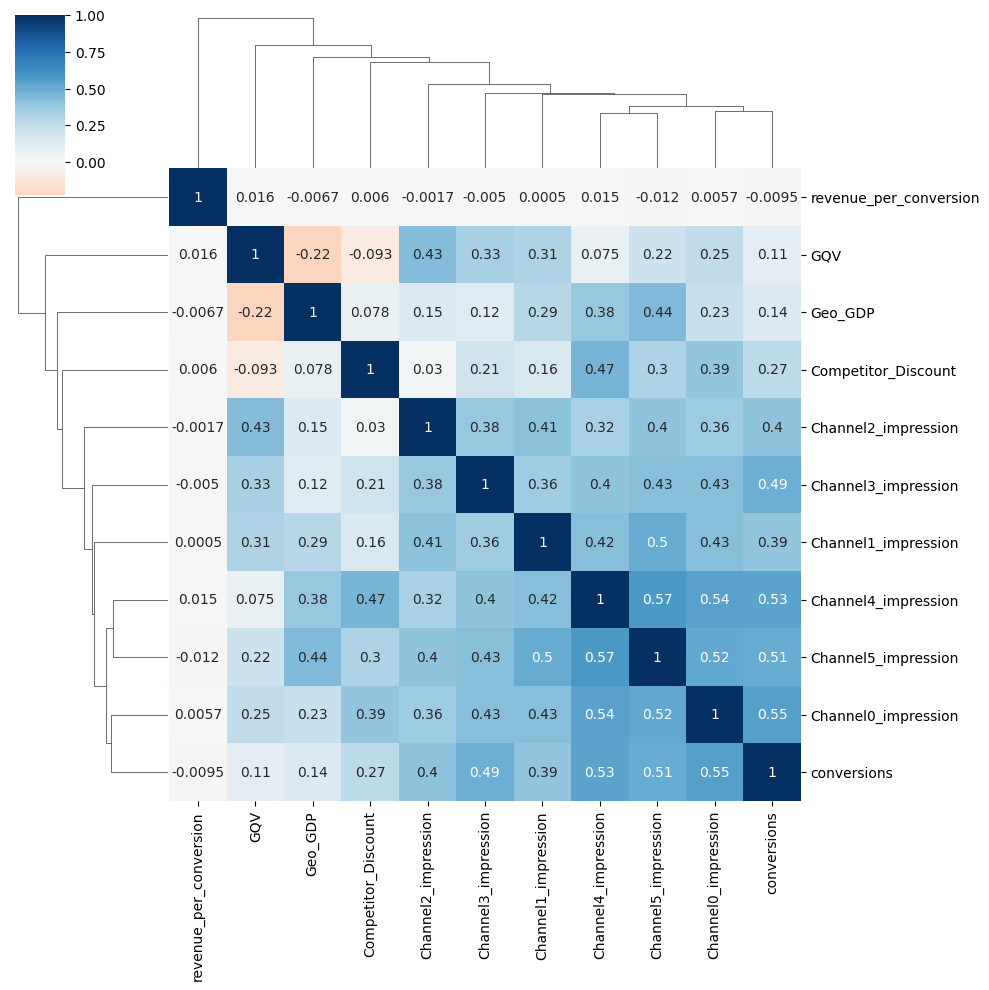

In [15]:
sns.clustermap(df[[
  'Channel0_impression',
  'Channel1_impression',
  'Channel2_impression',
  'Channel3_impression',
  'Channel4_impression',
  'Channel5_impression',
  'GQV',
  'Geo_GDP',
  'Competitor_Discount',
  'conversions',
  'revenue_per_conversion',
]].corr(), annot=True, cmap='RdBu', center=0);

## Lagged Correlation Between Impressions and Conversions

This chart shows the **Pearson correlation** between channel impressions and conversions across different time lags (0–14 days).  
It helps identify how quickly the effect of impressions is reflected in conversion activity.

### Key Observations
- **Highest Impact at Lag 0:**  
  All channels peak in correlation with conversions on the same day impressions occur, with `Channel0_impression` (~0.55) and `Channel4_impression` (~0.54) showing the strongest immediate effects.
  
- **Rapid Decay:**  
  Correlations drop sharply by lag 1 for all channels, suggesting that **most conversion influence happens within the same day** or very shortly after impressions.

- **Stabilization Over Time:**  
  After lag 2–3, correlations level off to a lower but relatively stable range (~0.20–0.30), indicating a **weaker and more sustained residual effect** over the following two weeks.

- **Channel Differences:**  
  - `Channel0`, `Channel3`, and `Channel4` maintain slightly higher sustained correlations, implying better persistence in driving conversions.  
  - `Channel1` consistently shows the lowest correlation across all lags, suggesting limited effectiveness.

### Implications
- For immediate conversion lift, **concentrating impressions in Channels 0, 3, and 4** is most impactful.  
- If the goal is to maintain a prolonged effect, a **steady flow of impressions** may be needed rather than relying on residual impact.  
- These insights can guide **flight scheduling** and **spend allocation timing** in campaigns.


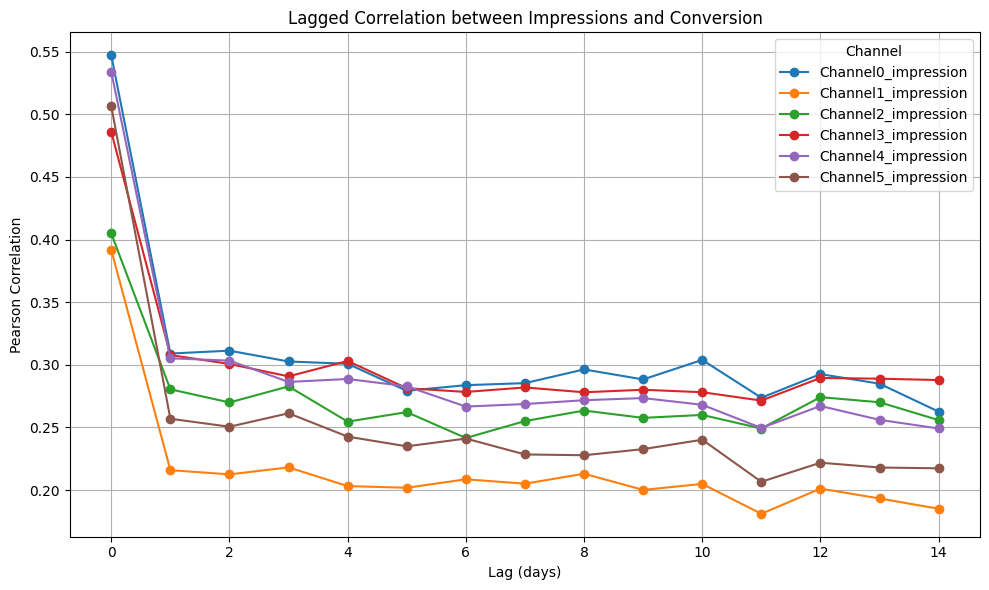

In [16]:
# List of channel impression variables
channel_cols = [
    'Channel0_impression',
    'Channel1_impression',
    'Channel2_impression',
    'Channel3_impression',
    'Channel4_impression',
    'Channel5_impression'
]

# Target variable
target = 'conversions'

# Max lag to test
max_lag = 14

# Dictionary to store correlations
correlation_results = {col: [] for col in channel_cols}

# Compute correlations for each lag
for lag in range(0, max_lag + 1):
    for col in channel_cols:
        # Shift the impression data forward by lag days
        shifted = df[col].shift(lag)
        corr = df[target].corr(shifted)
        correlation_results[col].append(corr)

# Convert results to a DataFrame
corr_df = pd.DataFrame(correlation_results, index=range(0, max_lag + 1))
corr_df.index.name = 'Lag'

# Plot the lagged correlations
corr_df.plot(figsize=(10, 6), marker='o')
plt.title('Lagged Correlation between Impressions and Conversion')
plt.xlabel('Lag (days)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.legend(title='Channel')
plt.tight_layout()
plt.show()


## Spend vs. Impression Variance by Channel

This scatter plot compares **total spend** (x-axis) with **variance in impressions** (y-axis) for each channel.  
It helps identify whether higher investments are associated with greater variability in exposure.

### Key Observations
- **High Spend & High Variance:**  
  `Channel0` and `Channel4` both have the highest spend and some of the highest impression variances, suggesting aggressive campaigns with fluctuating delivery.
  
- **High Variance, Moderate Spend:**  
  `Channel5` has relatively moderate spend but still exhibits **very high impression variance**, possibly indicating irregular bursts of activity rather than steady investment.

- **Moderate Spend & Moderate Variance:**  
  `Channel2` and `Channel3` show mid-range values for both spend and variance, pointing to more balanced delivery patterns.

- **Low Spend & Low Variance:**  
  `Channel1` stands out as having the lowest spend and lowest variance, indicating minimal campaign activity and consistent (but limited) delivery.

### Implications
- Channels with **high variance** may face delivery inefficiencies or be used for short-term tactical pushes.  
- **Consistent impression delivery** might be more suitable for branding, while **high-variance strategies** could align with short-term promotional bursts.  
- The relationship between spend and variance can guide budget allocation to balance **reach stability** vs. **campaign agility**.


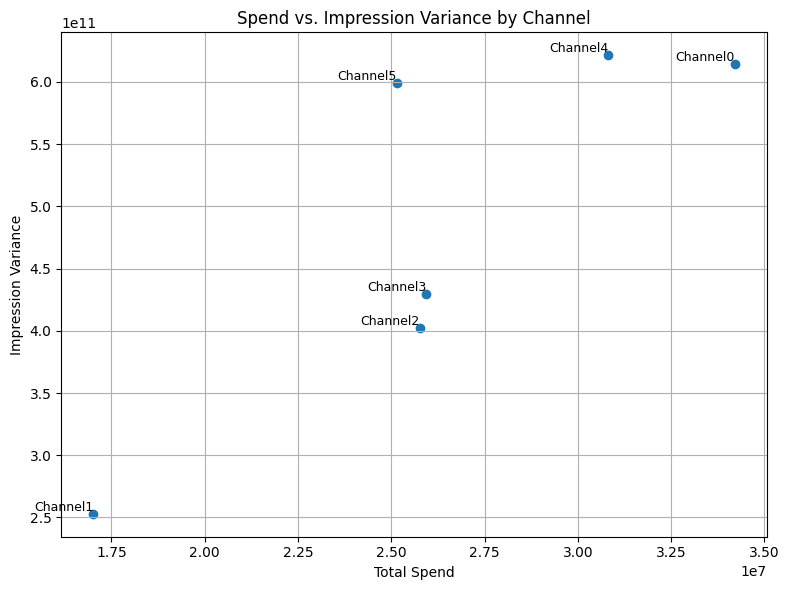

In [17]:
# Calculate x and y values
x_values = df.iloc[:, df.columns.str.contains('spend')].sum().tolist()
y_values = df.iloc[:, df.columns.str.contains('impression')].var().tolist()

# Generate labels
labels = [f'Channel{i}' for i in range(len(x_values))]

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values)

# Add text labels near each point
for i, label in enumerate(labels):
    plt.text(x_values[i], y_values[i], label, fontsize=9, ha='right', va='bottom')

plt.xlabel("Total Spend")
plt.ylabel("Impression Variance")
plt.title("Spend vs. Impression Variance by Channel")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2883222941.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=geos)


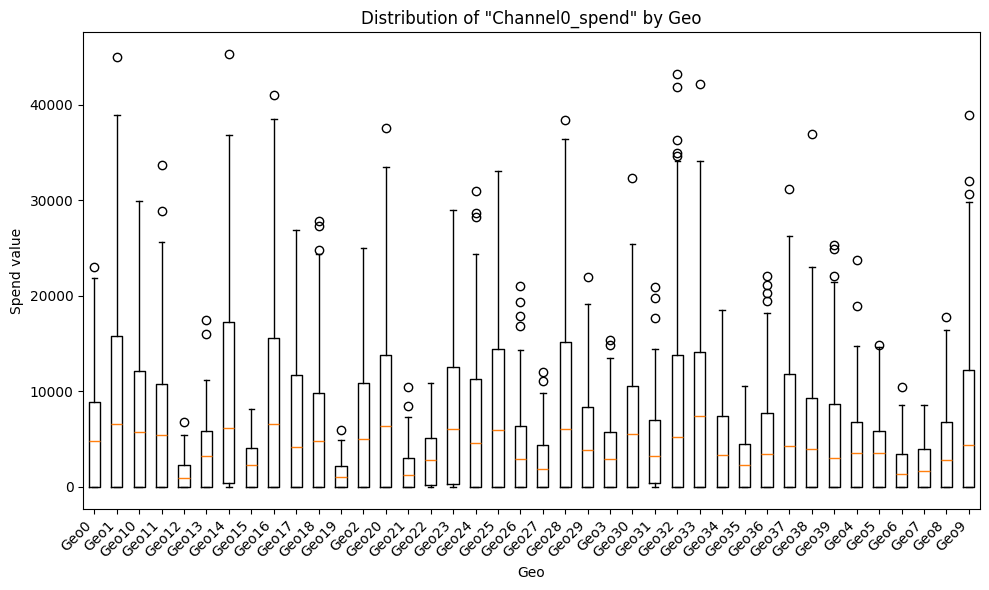

/tmp/ipython-input-2883222941.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=geos)


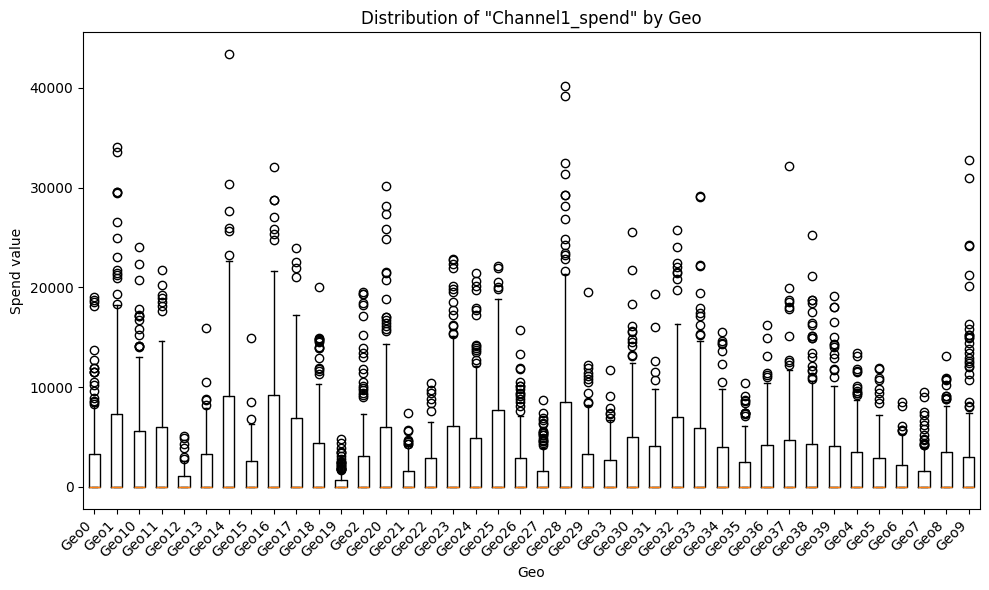

/tmp/ipython-input-2883222941.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=geos)


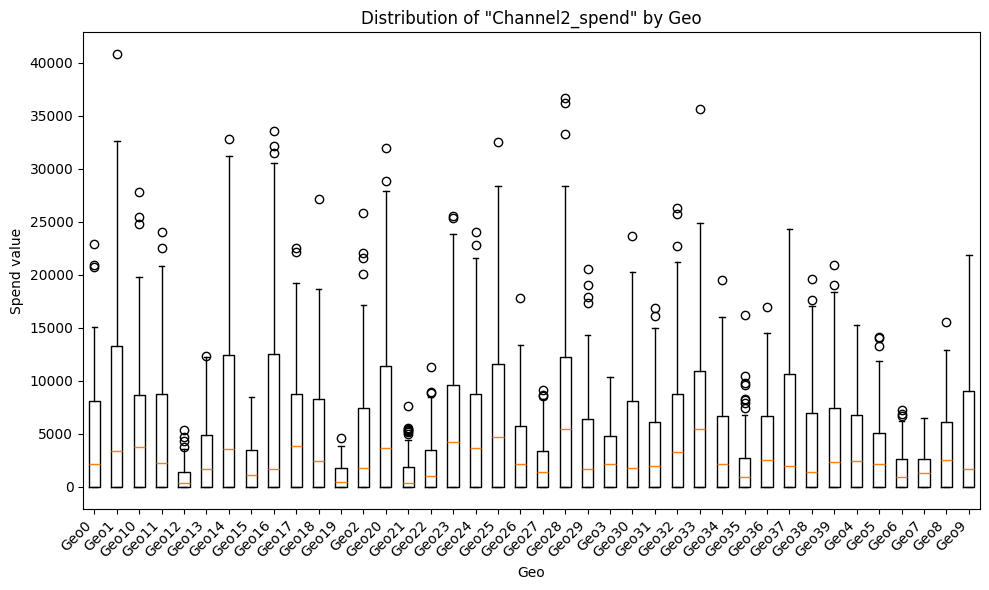

/tmp/ipython-input-2883222941.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=geos)


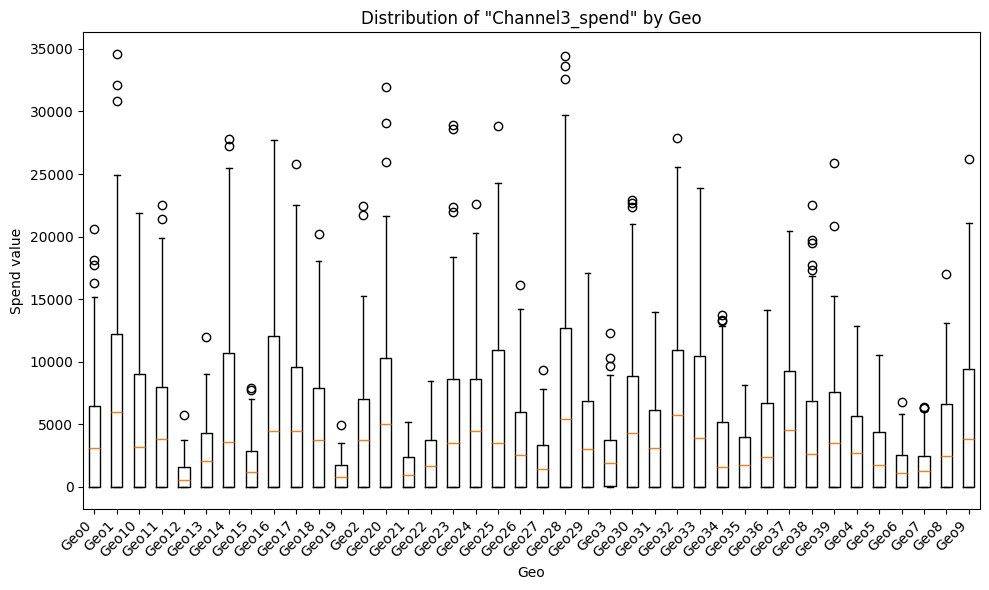

/tmp/ipython-input-2883222941.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=geos)


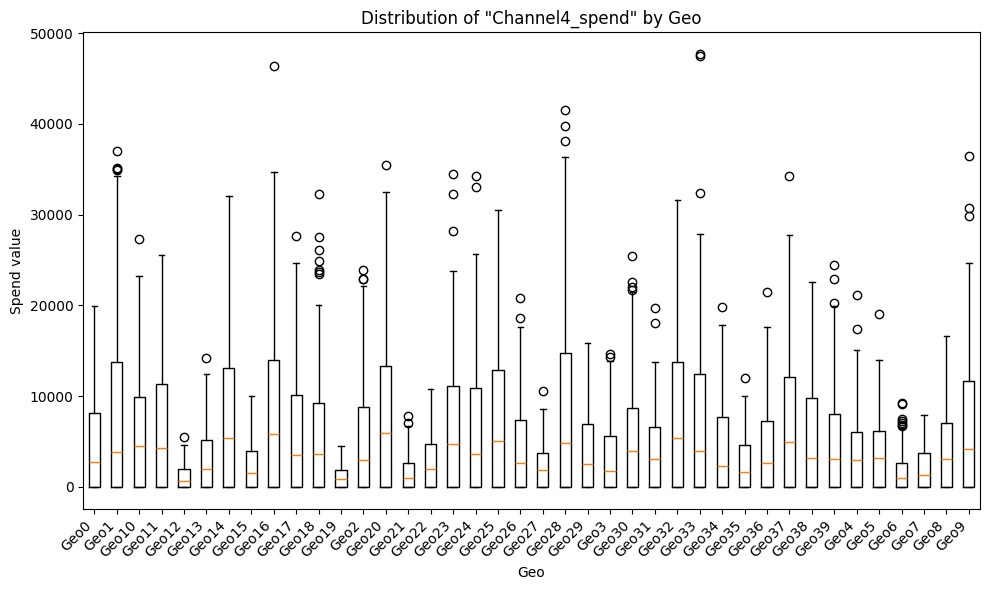

/tmp/ipython-input-2883222941.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=geos)


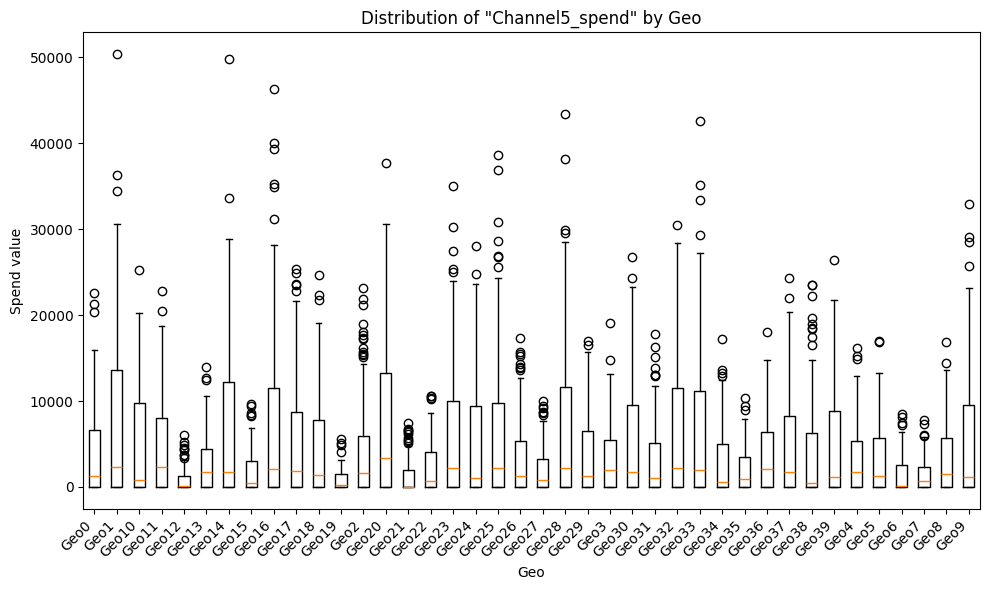

In [19]:
# Identify all spend columns
spend_cols = [col for col in df.columns if col.endswith('_spend')]

# Sorted list of geos
geos = sorted(df['geo'].dropna().unique())

for spend_col in spend_cols:
  # Prepare data per geo
    data = [df.loc[df['geo'] == geo, spend_col].dropna().values for geo in geos]

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(data, labels=geos)
    ax.set_title(f'Distribution of "{spend_col}" by Geo')
    ax.set_xlabel('Geo')
    ax.set_ylabel('Spend value')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Model Specification

## Rationale for Using Data-Guided Priors

Since this is an **exercise without credible external information**, we avoid asserting **informative priors** based on “expert knowledge.”  
Instead, we adopt **data-guided priors** that help guide estimation while preserving transparency about uncertainty.  
Our aim is to run a **crude estimation** and assess its performance against **Meridian’s modeling capabilities**.

### Approach
1. **Remove Common Time Effects:**  
   Apply **time fixed effects** to strip out shocks and seasonality common across all geos.

2. **Estimate Within-Geo Slopes:**  
   Use a **Mundlak-style specification** to estimate **within-unit effects** of conversions on spend, isolating the variation that comes from changes within each geo over time.

3. **Derive Priors from Observed Effects:**  
   Translate the within-geo effects into **ROI prior distributions**, providing a realistic yet non-committal starting point for the Bayesian model.

This approach ensures the priors are **empirically grounded** but not **overly deterministic**, allowing the model to learn flexibly from the data.


In [22]:
# =========================
# Config / column sets
# =========================
TIME = 'time'
GEO  = 'geo'
TARGET = 'conversions'
REV_PER = 'revenue_per_conversion'

# Build sets from your schema
impr_cols = [
    'Channel0_impression','Channel1_impression','Channel2_impression',
    'Channel3_impression','Channel4_impression','Channel5_impression'
]
spend_cols = [
    'Channel0_spend','Channel1_spend','Channel2_spend',
    'Channel3_spend','Channel4_spend','Channel5_spend'
]
rf_reach_cols = ['Channel4_reach','Channel5_reach']
rf_freq_cols  = ['Channel4_frequency','Channel5_frequency']
control_cols  = ['Competitor_Discount','GQV','Geo_GDP']
static_cols   = ['population','geo_tier']  # time-invariant within geo

predictors = impr_cols + rf_reach_cols + rf_freq_cols + spend_cols + control_cols + static_cols

# =========================
# Helpers
# =========================
def residualize_by_time(df, cols, time_col=TIME):
    """
    Residualize each column in `cols` on time fixed effects.
    Handles non-numeric inputs, NaNs, and returns residuals aligned to df.index.
    """
    # Stable categories for time FE
    tcat = pd.Categorical(df[time_col])
    Z = pd.get_dummies(tcat, drop_first=True)
    Z = sm.add_constant(Z).astype(float)  # numeric design

    out = pd.DataFrame(index=df.index, dtype=float)

    for c in cols:
        y = pd.to_numeric(df[c], errors='coerce')
        mask = y.notna()
        resid = pd.Series(np.nan, index=df.index, dtype=float)
        if mask.sum() > Z.shape[1]:  # enough obs to identify FE
            model = sm.OLS(y[mask].values, Z.loc[mask].values)
            res = model.fit()
            resid.loc[mask] = res.resid
        out[c] = resid

    return out

def per_geo_corr(df, x, y, geo=GEO):
    """
    Pearson r per geo + n (on already-clean residualized data).
    Subsets columns before groupby to avoid pandas apply deprecation.
    """
    sub = df[[geo, x, y]]
    def _f(d):
        s = d[[x, y]].dropna()
        n = len(s)
        if n < 4:
            return pd.Series({'r': np.nan, 'n': n})
        return pd.Series({'r': s[x].corr(s[y]), 'n': n})
    return sub.groupby(geo, group_keys=False).apply(_f, include_groups=False).reset_index()

def fisher_meta(geo_stats):
    """Global Fisher-z meta and I^2 heterogeneity across geos."""
    ok = geo_stats.dropna(subset=['r']).copy()
    if ok.empty:
        return np.nan, np.nan, np.nan
    ok['z'] = np.arctanh(ok['r'].clip(-0.999999, 0.999999))
    ok['w'] = ok['n'] - 3
    ok = ok[ok['w'] > 0]
    if ok.empty:
        return np.nan, np.nan, np.nan
    z_bar = np.average(ok['z'], weights=ok['w'])
    r_bar = np.tanh(z_bar)
    Q = np.sum(ok['w'] * (ok['z'] - z_bar) ** 2)
    df_Q = ok['w'].count() - 1
    I2 = max(0.0, (Q - df_Q) / Q) if np.isfinite(Q) and Q > 0 and df_Q > 0 else 0.0
    return r_bar, z_bar, I2

def slope_from_r(df_resid, x, y):
    """beta = r * sd(y)/sd(x) on residualized data."""
    s = df_resid[[x, y]].dropna()
    if len(s) < 4:
        return np.nan, np.nan
    r = s[x].corr(s[y])
    sx = s[x].std(ddof=1)
    sy = s[y].std(ddof=1)
    if sx == 0 or not np.isfinite(sx) or not np.isfinite(sy):
        return r, np.nan
    beta = r * (sy / sx)
    return r, beta

def slope_within_geo_mundlak(df_resid, x, y, geo=GEO):
    """
    Within-geo (Mundlak) slope on time-residualized data:
      x_w = x - mean_g(x), y_w = y - mean_g(y)
      beta_w = r(x_w, y_w) * sd(y_w)/sd(x_w)
    """
    s = df_resid[[geo, x, y]].dropna()
    if len(s) < 4:
        return np.nan, np.nan
    xw = s[x] - s.groupby(geo)[x].transform('mean')
    yw = s[y] - s.groupby(geo)[y].transform('mean')
    sx = xw.std(ddof=1)
    sy = yw.std(ddof=1)
    if sx == 0 or not np.isfinite(sx) or not np.isfinite(sy):
        return np.nan, np.nan
    r_w = xw.corr(yw)
    beta_w = r_w * (sy / sx)
    return r_w, beta_w

def lognormal_from_mean_cv(mean, cv):
    """Return (loc, scale) for LogNormal given mean and CV (sd/mean)."""
    mean = float(mean)
    if not np.isfinite(mean) or mean <= 0:
        return np.nan, np.nan
    scale = float(np.sqrt(np.log(1 + cv ** 2)))
    loc = float(np.log(mean) - 0.5 * scale ** 2)
    return loc, scale

def cv_from_strength(r_abs, I2):
    """Heuristic CV for ROI priors based on signal & heterogeneity."""
    if np.isnan(r_abs):
        return 0.9
    if r_abs >= 0.40 and (np.isnan(I2) or I2 < 0.25):   # strong & homogeneous
        return 0.5
    if r_abs >= 0.20 and (np.isnan(I2) or I2 < 0.50):   # moderate
        return 0.7
    return 0.9                                          # weak/heterogeneous

def eta_from_I2(I2):
    """Pooling suggestion: lower eta = stronger pooling across geos."""
    if np.isnan(I2): return 0.5
    if I2 < 0.25:    return 0.4
    if I2 < 0.50:    return 0.6
    return 1.0

def pick_channel(c):
    for ch in ['Channel0','Channel1','Channel2','Channel3','Channel4','Channel5']:
        if c.startswith(ch + '_'):
            return ch
    return None

# =========================
# Pipeline (no muta el df original)
# =========================

# 0) Trabajar SIEMPRE sobre una copia
df_aux = df.copy(deep=True)  # <- NUEVO, y no se toca más `df`

# 0a) Conversions per capita (solo en df_aux)
df_aux['conv_pc'] = df_aux[TARGET] / df_aux['population'].replace(0, np.nan)
YCOL = 'conv_pc'

# 0b) Coerción numérica (solo en df_aux)
numeric_like = predictors + [YCOL, TARGET, REV_PER]
df_aux[numeric_like] = df_aux[numeric_like].apply(pd.to_numeric, errors='coerce')

# 1) Residualización por tiempo (usa df_aux)
time_var_cols = [c for c in predictors if c not in static_cols]
resid = residualize_by_time(df_aux, time_var_cols + [YCOL], time_col=TIME)
work  = df_aux[[GEO, TIME]].join(resid)

# 2) Correlaciones & heterogeneidad (usa df_aux/work)
rows = []
for x in time_var_cols:
    geo_r = per_geo_corr(work, x, YCOL, geo=GEO)
    r_bar, z_bar, I2 = fisher_meta(geo_r)
    r_glob, beta = slope_from_r(work, x, YCOL)
    rows.append({
        'variable': x,
        'r_global_time_resid': r_glob,
        'r_meta_time_resid': r_bar,
        'I2_geo_heterogeneity': I2,
        'beta_global': beta,
        'n_geos_used': int(geo_r['n'].gt(3).sum())
    })
summary_timevary = pd.DataFrame(rows)

# 3) Predictoras estáticas (entre geos) — usa df_aux
rows_static = []
if len(static_cols):
    gy = df_aux.groupby(GEO, group_keys=False)[YCOL].mean()
    for x in static_cols:
        gx = df_aux.groupby(GEO, group_keys=False)[x].first()
        mask = gy.notna() & gx.notna()
        r = gy[mask].corr(gx[mask]) if mask.sum() >= 4 else np.nan
        rows_static.append({'variable': x, 'r_between_geo': r})
summary_static = pd.DataFrame(rows_static)

# 4) ROI priors (WITHIN-GEO slope) — todo con df_aux
resid_target_raw = residualize_by_time(df_aux, [TARGET], time_col=TIME)[TARGET]
work_roi = df_aux[[GEO, TIME]].copy()
work_roi = work_roi.join(resid[spend_cols])    # X residualizado
work_roi[TARGET] = resid_target_raw            # y residualizado

rev_mean = df_aux[REV_PER].dropna().mean()

roi_rows = []
for spend in spend_cols:
    r_within, beta_within = slope_within_geo_mundlak(work_roi, spend, TARGET, geo=GEO)
    geo_r_sp = per_geo_corr(work_roi, spend, TARGET, geo=GEO)
    r_bar_sp, _, I2_sp = fisher_meta(geo_r_sp)

    if np.isfinite(beta_within):
        roi_est = float(beta_within) * float(rev_mean)
        cv = cv_from_strength(abs(r_within), I2_sp)
        loc, scale = (lognormal_from_mean_cv(roi_est, cv) if roi_est > 0 else (np.nan, np.nan))
    else:
        roi_est, cv, loc, scale = (np.nan, np.nan, np.nan, np.nan)

    roi_rows.append({
        'variable': spend,
        'roi_point_estimate_$/$': roi_est,
        'cv_for_prior': cv,
        'lognormal_loc': loc,
        'lognormal_scale': scale,
        'eta_suggestion': eta_from_I2(I2_sp),
        'channel': pick_channel(spend),
        'r_global_within': r_within,
        'r_meta_rawconv': r_bar_sp,
        'I2_rawconv': I2_sp
    })
roi_priors = pd.DataFrame(roi_rows)

# 5) Arrays para Meridian (sin tocar df)
impr_channels = ['Channel0','Channel1','Channel2','Channel3']
rf_channels   = ['Channel4','Channel5']

roi_m  = roi_priors[roi_priors['channel'].isin(impr_channels)].set_index('channel').reindex(impr_channels)
roi_rf = roi_priors[roi_priors['channel'].isin(rf_channels)].set_index('channel').reindex(rf_channels)

roi_m_loc    = roi_m['lognormal_loc'  ].tolist()
roi_m_scale  = roi_m['lognormal_scale'].tolist()
roi_rf_loc   = roi_rf['lognormal_loc'  ].tolist()
roi_rf_scale = roi_rf['lognormal_scale'].tolist()

eta_m_suggest  = float(np.nanmean(roi_m['eta_suggestion']))  if len(roi_m)  else 0.5
eta_rf_suggest = float(np.nanmean(roi_rf['eta_suggestion'])) if len(roi_rf) else 0.5

# =========================
# Outputs
# =========================
print("\n=== Time-varying predictors: correlation & heterogeneity vs conv_pc (residualized by time) ===")
print(summary_timevary.sort_values('r_global_time_resid', ascending=False).to_string(index=False))

print("\n=== Static predictors: between-geo correlations (with conv_pc) ===")
print(summary_static.to_string(index=False))

print("\n=== ROI prior suggestions (spend variables; WITHIN-GEO slope, RAW conversions residualized by time) ===")
print(roi_priors[['variable','roi_point_estimate_$/$','cv_for_prior',
                  'lognormal_loc','lognormal_scale','eta_suggestion',
                  'r_global_within','I2_rawconv']].to_string(index=False))

print("\n=== Meridian arrays (use in PriorDistribution LogNormal for ROI) ===")
print("roi_m_loc   =", roi_m_loc)
print("roi_m_scale =", roi_m_scale)
print("roi_rf_loc  =", roi_rf_loc)
print("roi_rf_scale=", roi_rf_scale)
print(f"eta_m ~ {eta_m_suggest:.2f}   |   eta_rf ~ {eta_rf_suggest:.2f}")





=== Time-varying predictors: correlation & heterogeneity vs conv_pc (residualized by time) ===
           variable  r_global_time_resid  r_meta_time_resid  I2_geo_heterogeneity  beta_global  n_geos_used
Competitor_Discount             0.538750           0.605711              0.949559     2.223079           40
 Channel4_frequency             0.448317           0.492218              0.888004     1.628015           40
 Channel5_frequency             0.441310           0.489027              0.907923     1.574936           40
Channel4_impression             0.345664           0.467278              0.864955     0.000002           40
     Channel4_spend             0.345664           0.467278              0.864955     0.000241           40
     Channel5_spend             0.343594           0.451625              0.899488     0.000252           40
Channel5_impression             0.343594           0.451625              0.899488     0.000002           40
Channel0_impression             0.339363

## Structuring the Input for Meridian

In this step, we **mapped the raw DataFrame** into Meridian’s expected schema, organizing the data so the model can correctly interpret each variable’s role.

### Media Channel Grouping
- **Impressions-based channels:** Focused on exposure counts, representing the volume of ad impressions delivered.
- **Reach/frequency channels:** Capturing both **audience breadth** (reach) and **message repetition** (frequency).

### Additional Inputs
Alongside media variables, we included:
- **KPI metrics** (e.g., conversions)
- **Population** and **revenue-per-KPI** measures
- **External control variables** to reflect market and competitive conditions

### Purpose
This transformation converts the dataset from a **flat table** into a **semantically organized structure**, explicitly linking each feature to its analytical role.  
By doing so, we ensure that Meridian can **evaluate media impact** within the **appropriate market and competitive context**.


In [23]:
# --- Channel sets from schema ---
media_channels = ["Channel0","Channel1","Channel2","Channel3"]     # impressions-based
rf_channels    = ["Channel4","Channel5"]                           # reach/frequency-based


# --- Builder ---
builder = data_frame_input_data_builder.DataFrameInputDataBuilder(
    kpi_type='non_revenue',
    default_geo_column='geo',
    default_time_column='time',
    default_media_time_column='time',
    default_population_column='population',
    default_kpi_column='conversions',
    default_revenue_per_kpi_column='revenue_per_conversion'
)

builder = (
    builder.with_kpi(df)
           .with_revenue_per_kpi(df)
           .with_population(df)
           .with_controls(df, control_cols=["GQV", "Geo_GDP", "Competitor_Discount"])
)

# Impressions-based media: Channels 0–3
builder = builder.with_media(
    df,
    media_cols=[f"{c}_impression" for c in media_channels],
    media_spend_cols=[f"{c}_spend" for c in media_channels],
    media_channels=media_channels,
)

# Reach/Frequency media: Channels 4–5
builder = builder.with_reach(
    df,
    reach_cols=[f"{c}_reach" for c in rf_channels],
    frequency_cols=[f"{c}_frequency" for c in rf_channels],
    rf_channels=rf_channels,
    rf_spend_cols=[f"{c}_spend" for c in rf_channels],
)

data = builder.build()


**Overall stance.** We use **weakly informative priors** to regularize estimation without imposing strong beliefs. Priors are **data-guided** (from our within-geo diagnostics) but kept broad; when in doubt, we bias toward **more conservative** (weaker) priors.

**ROI priors (paid media).**
Meridian accepts priors on **ROI** (not directly on coefficients). For each channel we set

$$
\mathrm{ROI}_i \sim \mathrm{LogNormal}(\mu_i,\sigma_i),
$$

with $\mu_i=\log(\widehat{\mathrm{ROI}}_i)$ taken from our **within-geo (Mundlak) slope** of conversions on spend (time-residualized), multiplied by average revenue per conversion. We use **broad scales** $\sigma_i\approx 0.8$ to keep the priors weak. These are passed as `roi_m_loc/scale` for impressions-based channels and `roi_rf_loc/scale` for reach/frequency channels (order aligned to the data object). Meridian internally maps these ROI priors to the model’s media coefficients.

**Hierarchical heterogeneity (η).**
Between-geo variation of channel effects uses a hierarchical SD parameter $\eta$. We keep the defaults:

$$
\eta_{\text{media}},\ \eta_{\text{rf}} \sim \mathrm{HalfNormal}(1.0),
$$

which are **weakly informative** and permit substantial cross-geo dispersion (appropriate given our high $I^2$). Smaller scales would force stronger pooling; we avoid that unless diagnostics indicate over-dispersion control is needed.

**Residual variance structure.**
We keep a **shared residual variance** across geos (`unique_sigma_for_each_geo=False`) for stability and regularization.

**Knots**
We initialy run the model under the default values. We observed nontheless issues in the convergence and also overfitting. Therefore we reduce the **number of knots** to 5.



In [24]:
from meridian.model import spec, prior_distribution
import tensorflow_probability as tfp
from meridian import constants

tfd = tfp.distributions

# Arrays in (log-space) calculated:
roi_m_loc   = [1.0959383659420885, 1.0150874900906408, 0.6710387096114658, 1.1208330823826635]
roi_m_scale = [0.7702771223902047, 0.7702771223902047, 0.7702771223902047, 0.7702771223902047]   # Use calculated scales
roi_rf_loc  = [1.1507748148395502, 1.178759696372007]
roi_rf_scale= [0.7702771223902047, 0.7702771223902047] # Use calculated scales
eta_m = 1.00
eta_rf = 1.00


priors = prior_distribution.PriorDistribution(
    roi_m  = tfd.LogNormal(roi_m_loc,  roi_m_scale,  name=constants.ROI_M),
    roi_rf = tfd.LogNormal(roi_rf_loc, roi_rf_scale, name=constants.ROI_RF),
    eta_m  = tfd.HalfNormal(eta_m, name=constants.ETA_M),
    eta_rf = tfd.HalfNormal(eta_rf, name=constants.ETA_RF),
)

model_spec = spec.ModelSpec(prior=priors, knots=5)  # prior_type by defect is 'roi'

In [25]:
mmm = model.Meridian(input_data=data, model_spec=model_spec)

In [26]:
%%time
mmm.sample_prior(500)
mmm.sample_posterior(
    n_chains=10, n_adapt=2000, n_burnin=500, n_keep=1000, seed=0
)

CPU times: user 16min 15s, sys: 22.2 s, total: 16min 37s
Wall time: 16min 47s


# Model Diagnostics

## Model Convergence Diagnostics – R-hat

The **R-hat convergence diagnostic** evaluates whether the model’s Markov Chain Monte Carlo (MCMC) chains have converged to a stable posterior distribution.

- **Interpretation:**  
  - An **R-hat value close to 1.0** indicates good convergence.  
  - Values **above 1.05** suggest potential non-convergence for a parameter, meaning more sampling or model refinement may be needed.
- **Findings:**  
  - Most parameters cluster tightly around **1.000–1.005**, showing excellent convergence.
  - A few parameters (e.g., `gamma_c` and `x_i_c`) are slightly higher (~1.01–1.025), but still within an acceptable range for practical purposes.
- **Conclusion:**  
  Overall, the model demonstrates **strong convergence** with only minor deviations, which are unlikely to materially impact inference. However, parameters with higher R-hat could be monitored or targeted for additional sampling if further precision is desired.


In [27]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

## Expected vs. Actual Revenue

This chart compares **expected revenue** from the model against **actual observed revenue**, with a **baseline** scenario for reference.

- **Expected Revenue (blue):** The model’s projection of revenue, incorporating media effects, market conditions, and other drivers.
- **Actual Revenue (green):** Observed revenue data over the same time period.
- **Baseline (orange):** Estimated revenue without the incremental contribution of media, representing a “no-media” or neutral scenario.

### Insights
- The expected and actual revenue lines track closely, indicating the model captures key drivers effectively.
- Variations between the blue and green lines represent short-term deviations that may be due to noise, unmodeled events, or market shocks.
- The gap between the baseline (orange) and expected (blue) lines reflects the **estimated media lift**—the additional revenue attributed to marketing efforts.

### Conclusion
The model demonstrates **strong predictive alignment** with observed data and provides a meaningful counterfactual baseline for evaluating marketing impact.


In [28]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

alt.LayerChart(...)

# Model Output

In [29]:
mmm_summarizer = summarizer.Summarizer(mmm)

In [30]:
filepath = '/content/'
mmm_summarizer.output_model_results_summary(
    'summary_output.html', filepath, df['time'].min(), df['time'].max()
)

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:3103: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(


## Model Summary – Marketing Mix Modeling (MMM)

This summary outlines the key outputs from the MMM analysis, providing insights into channel performance, ROI, and model fit.

### Key Components
- **Model Fit Metrics:** Statistical measures indicate strong alignment between predicted and observed KPI values, validating the model’s explanatory power.
- **Channel Contributions:** The model estimates each media channel’s incremental effect on the KPI, controlling for market conditions and external variables.
- **ROI Estimates:** Return on investment is calculated per channel, allowing comparison of cost efficiency across different media types.
- **Credible Intervals:** Bayesian credible intervals provide uncertainty ranges, ensuring results are interpreted with appropriate caution.
- **Baseline KPI:** Represents expected performance without media investment, serving as a reference point for evaluating lift.

### Use Cases
- **Budget Allocation:** Identify high-ROI channels for increased investment.
- **Performance Diagnosis:** Understand which channels contribute most to KPI growth.
- **Scenario Planning:** Model potential outcomes under different media spend configurations.

**Conclusion:**  
The model offers a robust foundation for data-driven marketing decisions, balancing statistical rigor with actionable business insights.


In [31]:
IPython.display.HTML(filename=f'{filepath}/summary_output.html')

Dataset,R-squared,MAPE,wMAPE
All Data,0.90,2%,2%


# Optimization

In [32]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

CPU times: user 35.2 s, sys: 1.8 s, total: 37 s
Wall time: 46.3 s


In [33]:
optimization_results.output_optimization_summary(
    'optimization_output.html', filepath
)

## Budget Optimization Results

The optimization output provides a **spend reallocation strategy** aimed at maximizing the target KPI within the same overall budget.

### Key Insights
- **Optimal Spend Distribution:**  
  The recommended allocation shifts investment toward channels with higher estimated ROI and stronger incremental contribution.
- **Underperforming Channels:**  
  Channels with lower efficiency receive reduced or zero recommended spend, freeing budget for higher-impact areas.
- **Projected KPI Lift:**  
  Implementing the optimized mix is expected to yield a measurable increase in conversions compared to the current allocation, without increasing total spend.
- **Marginal ROI Equalization:**  
  The optimization balances spend so that the **marginal ROI** across active channels is approximately equal, ensuring no channel is over- or under-invested.

### Practical Use
- Apply these recommendations in upcoming campaign cycles to **improve efficiency**.
- Use as a baseline for **scenario testing**—e.g., adjusting total budget or imposing channel-specific constraints.
- Monitor performance post-implementation to validate predicted gains and refine model parameters.

**Conclusion:**  
The optimization serves as a **data-driven roadmap** for allocating media budgets more effectively, maximizing returns under current constraints.


In [34]:
IPython.display.HTML(filename=f'{filepath}/optimization_output.html')

Channel,Non-optimized spend,Optimized spend
Channel4,19%,25%
Channel5,16%,21%
Channel0,22%,17%
Channel1,11%,14%
Channel3,16%,12%
Channel2,16%,11%
